Epoch 1/80
2/2 [==============================] - 3s 801ms/step - loss: 143.4749 - val_loss: 13.7888
Epoch 2/80
2/2 [==============================] - 1s 448ms/step - loss: 2528.4473 - val_loss: 17.6388
Epoch 3/80
2/2 [==============================] - 1s 659ms/step - loss: 3866.3379 - val_loss: 9.8831
Epoch 4/80
2/2 [==============================] - 1s 386ms/step - loss: 2896.1123 - val_loss: 12.5759
Epoch 5/80
2/2 [==============================] - 1s 388ms/step - loss: 5429.4009 - val_loss: 26.3527
Epoch 6/80
2/2 [==============================] - 1s 316ms/step - loss: 6730.9468 - val_loss: 40.7817
Epoch 7/80
2/2 [==============================] - 1s 402ms/step - loss: 5237.6675 - val_loss: 41.9358
Epoch 8/80
2/2 [==============================] - 1s 394ms/step - loss: 4526.1851 - val_loss: 34.5438
Epoch 9/80
2/2 [==============================] - 1s 386ms/step - loss: 6182.9258 - val_loss: 28.6768
Epoch 10/80
2/2 [==============================] - 1s 390ms/step - loss: 6269.0864 -

1/1 [==============================] - 0s 93ms/step
RMSE Systolic: 4.1806371374426305
RMSE Diastolic: 8.304608923426732
Best Validation Loss: 2.0302979946136475
Best Training Loss: 85.9410629272461


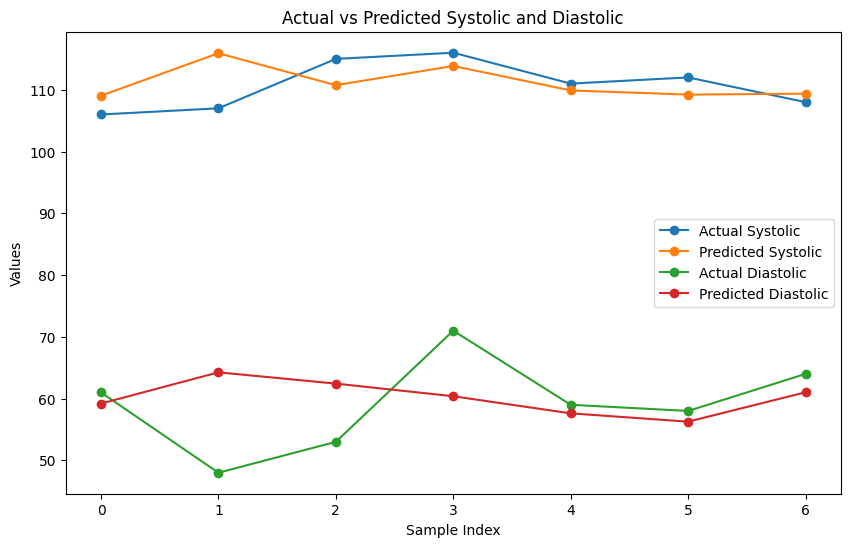

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
signal = np.load('signal.npy')  # (61, 29400, 4)
csv_data = pd.read_csv('data.csv')


X = signal.reshape(signal.shape[0], -1)
y_systolic = csv_data['Systolic']
y_diastolic = csv_data['Diastolic']

# Split data into training, validation, and testing sets
X_train, X_temp, y_train_systolic, y_temp_systolic, y_train_diastolic, y_temp_diastolic = train_test_split(
    X, y_systolic, y_diastolic, test_size=0.2, random_state=42
)

X_val, X_test, y_val_systolic, y_test_systolic, y_val_diastolic, y_test_diastolic = train_test_split(
    X_temp, y_temp_systolic, y_temp_diastolic, test_size=0.5, random_state=42
)

y_train_systolic_normalized = (y_train_systolic - y_train_systolic.mean()) / y_train_systolic.std()
y_test_systolic_normalized = (y_test_systolic - y_test_systolic.mean()) / y_test_systolic.std()
y_val_systolic_normalized = (y_val_systolic - y_val_systolic.mean()) / y_val_systolic.std()
y_train_diastolic_normalized = (y_train_diastolic - y_train_diastolic.mean()) / y_train_diastolic.std()
y_test_diastolic_normalized = (y_test_diastolic - y_test_diastolic.mean()) / y_test_diastolic.std()
y_val_diastolic_normalized = (y_val_diastolic - y_val_diastolic.mean()) / y_val_diastolic.std()

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.fit_transform(X_test)
X_val_scaled = scaler_x.fit_transform(X_val)


def custom_loss(y_true, y_pred):
    loss_systolic = tf.keras.losses.mean_squared_error(y_true[:, 0], y_pred[:, 0])
    loss_diastolic = tf.keras.losses.mean_squared_error(y_true[:, 1], y_pred[:, 1])
    return loss_systolic + loss_diastolic


model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.1),  # Add dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Add dropout
    tf.keras.layers.Dense(2, activation='linear')  # Two output layers for systolic and diastolic
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=custom_loss)

history = model.fit(X_train_scaled,
                    np.vstack((y_train_systolic_normalized, y_train_diastolic_normalized)).T,
                    epochs= 80,
                    validation_data=(X_val_scaled,
                                     np.vstack((y_val_systolic_normalized, y_val_diastolic_normalized)).T))

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)
y_pred_systolic_original_scale = (y_pred[:, 0] * y_test_systolic.std()) + y_test_systolic.mean()
y_pred_diastolic_original_scale = (y_pred[:, 1] * y_test_diastolic.std()) + y_test_diastolic.mean()

# Evaluate the model on the test set in the original scale
mse_systolic_original_scale = mean_squared_error(y_test_systolic, y_pred_systolic_original_scale)
rmse_systolic_original_scale = np.sqrt(mse_systolic_original_scale)
mse_diastolic_original_scale = mean_squared_error(y_test_diastolic, y_pred_diastolic_original_scale)
rmse_diastolic_original_scale = np.sqrt(mse_diastolic_original_scale)

print(f"RMSE Systolic: {rmse_systolic_original_scale}")
print(f"RMSE Diastolic: {rmse_diastolic_original_scale}")

# Plot actual vs predicted for systolic and diastolic
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for systolic
plt.plot(y_test_systolic.values, label='Actual Systolic', marker='o')
plt.plot(y_pred_systolic_original_scale, label='Predicted Systolic', marker='o')

# Plot actual vs predicted for diastolic
plt.plot(y_test_diastolic.values, label='Actual Diastolic', marker='o')
plt.plot(y_pred_diastolic_original_scale, label='Predicted Diastolic', marker='o')

print(history)
best_val_loss = min(history.history['val_loss'])
print("Best Validation Loss:", best_val_loss)
best_loss = min(history.history['loss'])
print("Best Training Loss:", best_loss)
# training_accuracy = max(history.history['accuracy'])
# print("Best training_accuracy:", training_accuracy)
# validation_accuracy = max(history.history['val_accuracy'])
# print("Best validation_accuracy:", validation_accuracy)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Systolic and Diastolic')
plt.legend()
plt.savefig('actual_vs_predicted_plot_100_epoch.png')
plt.show()
